# Practica ocho

Grupo 14:
* Joaquín Ibáñez Penalva
* Aurora Zuoris

Para la realización de esta práctica se usará la librería de numpy, pandas, matplotlib, y sklearn.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Ejercicio 1


In [ ]:
df = pd.read_csv('datos_svm.csv')
df.head()

In [ ]:
# Obtener un clasificador SVM lineal para cada uno de los siguientes valores de C, {0.01, 1, 10}, con todas las muestras del conjunto de datos
from sklearn.svm import SVC

# Crear los clasificadores SVM lineales con diferentes valores de C
C_values = [0.01, 1, 10]
classifiers = []
X = df[['x1', 'x2']].values
y = df['y'].values
for C in C_values:
    clf = SVC(kernel='linear', C=C, random_state=0)
    clf.fit(X, y)
    classifiers.append(clf)
    print(clf.score(X, y))



In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(5, 15))
for clf_i, clf in enumerate(classifiers):
    # Crea una malla de puntos para representar las superficies de decisión
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    x_range = np.arange(x_min, x_max, 0.02)

    for i in range(clf.coef_.shape[0]): # Para cada clase
        line = - (clf.coef_[i,0] / clf.coef_[i,1]) * x_range - (clf.intercept_[i] / clf.coef_[i,1]) # Ecuación de la recta
        axes[clf_i].plot(x_range, line, color="blue") 


    axes[clf_i].scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired) 
    axes[clf_i].scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], marker='x', color='red', alpha = 0.5) # Muestras de soporte en cruces rojas
    # Configurar el gráfico
    axes[clf_i].set_ylim(y_min, y_max)
    axes[clf_i].set_title(f'SVM lineal (C = {C_values[clf_i]})')


Se puede observar como conforme vamos aumentando el valor de C, el número de vectores de soporte disminuye. A mayor número de vectores soporte, el margen es mayor lo que puede cambiar la frontera de decisión. En general, cuanto mayor es el valor de C, más preciso debería ser el modelo, sin embargo en este caso, el que mayor score tiene es el 0.1 (85%). Además, cabe destacar que no estamos dividiendo los datos en train y test, sino que estamos utilizando los datos en su totalidad. Por esto, el score se debe interpretar más como cuanto de bien se ajusta el modelo con los datos que se entrena, más que su precisión en general, dado que puede que ocurra overfitting.

## Ejercicio 2

In [4]:
train_df = pd.read_csv('CelebA-10K-train.csv')
test_df = pd.read_csv('CelebA-10K-test.csv')

train_df.shape, test_df.shape

((5000, 514), (5000, 514))

In [5]:
X_train = train_df.iloc[:,2:]
y_train = train_df.iloc[:,1]
X_test = test_df.iloc[:,2:]
y_test = test_df.iloc[:,1]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5000, 512), (5000,), (5000, 512), (5000,))

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param = {
  "kernel": ['linear', 'poly', 'rbf'],
  "C": [0.1, 1, 10, 100, 1000],
}

grid = GridSearchCV(SVC(), param, verbose=4, n_jobs=-1)
grid.fit(X_train, y_train)
grid.best_params_


Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 3/5] END ..............C=0.1, kernel=linear;, score=0.886 total time=  18.3s
[CV 5/5] END ..............C=0.1, kernel=linear;, score=0.892 total time=  18.6s
[CV 4/5] END ..............C=0.1, kernel=linear;, score=0.899 total time=  18.8s
[CV 2/5] END ..............C=0.1, kernel=linear;, score=0.909 total time=  18.9s
[CV 1/5] END ..............C=0.1, kernel=linear;, score=0.918 total time=  19.5s
[CV 1/5] END ................C=0.1, kernel=poly;, score=0.591 total time=  47.5s
[CV 3/5] END ................C=0.1, kernel=poly;, score=0.587 total time=  47.8s
[CV 2/5] END ................C=0.1, kernel=poly;, score=0.592 total time=  48.8s
[CV 2/5] END .................C=0.1, kernel=rbf;, score=0.900 total time=  35.8s
[CV 3/5] END .................C=0.1, kernel=rbf;, score=0.858 total time=  35.8s
[CV 1/5] END .................C=0.1, kernel=rbf;, score=0.906 total time=  37.0s
[CV 4/5] END ................C=0.1, kernel=poly;

{'C': 10, 'kernel': 'rbf'}

In [15]:
svc = SVC(random_state=42, **grid.best_params_)
svc.fit(X_train, y_train)
accuracy = svc.score(X_test, y_test)
print(f"Taza de acierto: {accuracy:.2%}")

Taza de acierto: 95.38%


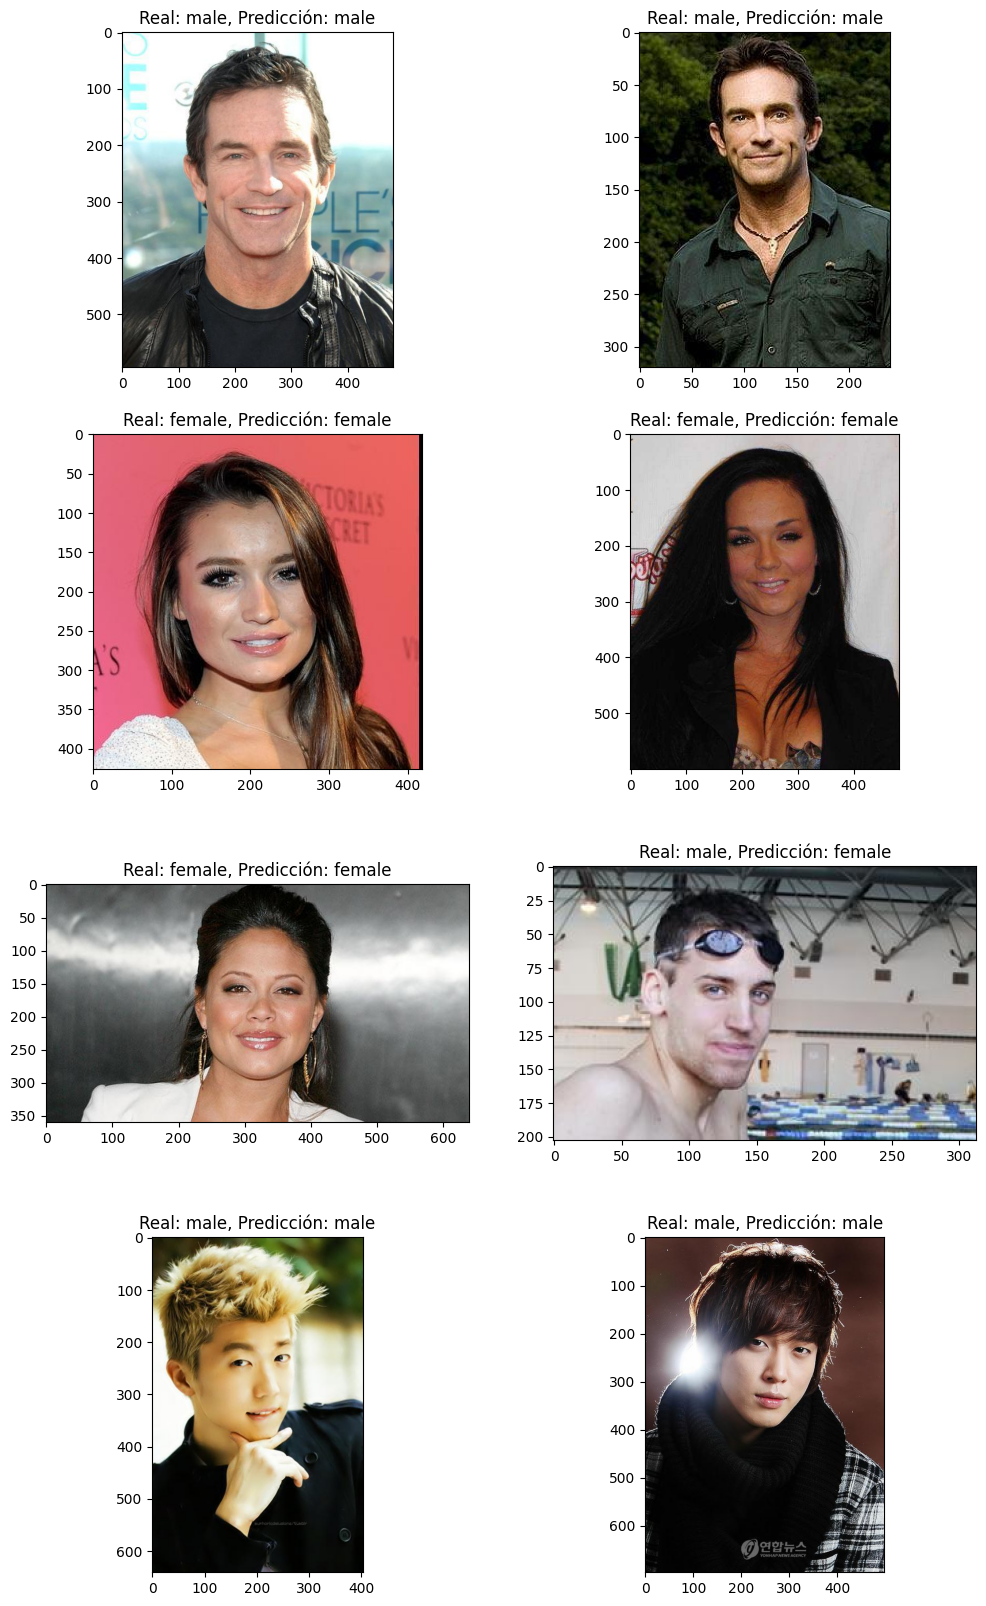

In [13]:
from pathlib import Path
import matplotlib.image as mpimg
fig, axs = plt.subplots(4, 2, figsize=(12, 20))

# Se iteran por los archivos de la carpeta img
for i, file in enumerate(Path("img").glob("*")):
  row = test_df[test_df["Image_name"] == file.name]
  prediction = svc.predict(row.iloc[:,2:])
  real = row.iloc[:,1]
  img = mpimg.imread(str(file))
  axs[i//2, i%2].imshow(img) # type: ignore
  axs[i//2, i%2].set_title(f"Real: {real.values[0]}, Predicción: {prediction[0]}") # type: ignore

Comparado con el otro modelo usando la regresión logística, hay una mejora del 4% en el conjunto de test, subiendo del 91% al 95%. Además, en las imagenes de prueba, sube de 4/8 a 7/8. Con lo que se puede concluir que este modelo es mejor que el anterior para este problema.